#### Identifying bird species infected with H5N1 and finding bird density from past 30 days in Chicago (as of 7/15/2025).   
By: Angel Moreno

In [7]:
import pandas as pd
import geopandas as gpd
import os
import requests
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from datetime import datetime, timedelta
import numpy as np
from shapely.geometry import box
from dotenv import load_dotenv
import libpysal
from esda import getisord

#### Bird species infected with H5N1 in Midwestern states of interest:

In [8]:
df = pd.read_csv("HPAI Detections in Wild Birds.csv")

mw_states_of_interest = ["Illinois", "Wisconsin", "Michigan"]
dead_birds = df[(df["HPAI Strain"].str.contains("H5N1")) & (df["State"].isin(mw_states_of_interest)) & (df["Sampling Method"]=="Morbidity/Mortality")]
dead_birds["Bird Species"].unique()

array(['Bald eagle', 'Peregrine falcon', 'Sandhill crane',
       'Red-tailed hawk', 'Herring gull', 'Red-breasted merganser',
       'Great horned owl', 'Hawk (unidentified)', 'American crow',
       'Canada goose', 'Trumpeter swan', 'Bufflehead', 'Snowy owl',
       'Tundra swan', 'Chilean flamingo', 'Barred owl', 'Mallard',
       'Hooded merganser', 'Common loon', 'European starling',
       'Snow goose', 'Canvasback', 'Crow (unidentified)', "Ross's goose",
       'American white pelican', 'Common tern', 'Swan (unidentified)',
       'Blue-winged teal', 'Goose (unidentified)', 'Great blue heron',
       'Great egret', 'Pelican (unidentified)', 'Ring-billed gull',
       'Caspian tern', 'Double-crested cormorant', 'Wood duck',
       'Redhead duck', 'Red-winged blackbird', 'Gadwall',
       'Turkey vulture', 'Common raven', 'Ruddy duck',
       'Eagle (unidentified)', 'Rough-legged hawk', 'Red-shouldered hawk',
       "Cooper's hawk", 'Wood Duck', 'Mute swan',
       'Cormorant (uni

In [9]:
# Illinois only
dead_birds_il = df[(df["HPAI Strain"].str.contains("H5N1")) & (df["State"] == "Illinois") & (df["Sampling Method"]=="Morbidity/Mortality")]
dead_birds_il["Bird Species"].unique()

array(['Chilean flamingo', 'Red-breasted merganser', 'Bufflehead',
       'Canada goose', 'Mallard', 'Hooded merganser', 'Sandhill crane',
       'Snow goose', 'Crow (unidentified)', 'Bald eagle',
       'Red-tailed hawk', 'Great horned owl', "Ross's goose",
       'American white pelican', 'Common tern', 'Goose (unidentified)',
       'Swan (unidentified)', 'Pelican (unidentified)',
       'Double-crested cormorant', 'Turkey vulture',
       'Cormorant (unidentified)'], dtype=object)

#### Chicago Bird Migration 30-Day Data (eBird):

In [10]:
# load_dotenv() 

# api_key = os.getenv("EBIRD_API_KEY")
# headers = {"X-eBirdApiToken": api_key}

# params = {
#     # lat and lng corresponds to downtown chicago
#     # 300 S Federal St, Chicago, IL 60604
#     "lat": 41.864231,
#     "lng": -87.627706,
#     "dist": 30, # this covers O'Hare and covers Blue Island
#     "back": 30, # past 30 days
#     "maxResults": 10000
# }

# response = requests.get(
#     "https://api.ebird.org/v2/data/obs/geo/recent",
#     headers=headers,
#     params=params
# )

In [11]:
load_dotenv()

api_key = os.getenv("EBIRD_API_KEY")
headers = {"X-eBirdApiToken": api_key}

# Location details for downtown Chicago
lat = 41.864231
lng = -87.627706
dist = 30  # in km

# Date range: June 18 – July 18, 2025
start_date = datetime(2025, 6, 18)
end_date = datetime(2025, 7, 18)

all_data = []

for i in range((end_date - start_date).days + 1):
    date = start_date + timedelta(days=i)
    url = f"https://api.ebird.org/v2/data/obs/US-IL-031/historic/{date.year}/{date.month:02}/{date.day:02}"

    response = requests.get(url, headers=headers, params={"maxResults": 10000})
    
    if response.status_code == 200:
        day_data = response.json()

        # Optional: filter by lat/lng radius manually
        filtered = [
            obs for obs in day_data
            if abs(obs.get("lat", 0) - lat) <= 0.27 and abs(obs.get("lng", 0) - lng) <= 0.37
        ]
        all_data.extend(filtered)
    else:
        print(f"Failed on {date.strftime('%Y-%m-%d')}: {response.status_code}")

# Convert to DataFrame and save
df = pd.DataFrame(all_data)
df.to_csv("ebird_june18_july18_2025.csv", index=False)

In [12]:
df.shape

(2693, 14)

In [13]:
df.head()

,speciesCode,comName,sciName,locId,locName,obsDt,howMany,lat,lng,obsValid,obsReviewed,locationPrivate,subId,exoticCategory
0,comnig,Common Nighthawk,Chordeiles minor,L38527359,4724 Virginia,2025-06-18 21:49,1.0,41.966950,-87.699166,True,False,True,S251882640,NaN
1,houspa,House Sparrow,Passer domesticus,L40927552,Home,2025-06-18 19:14,5.0,42.078816,-87.943196,True,False,True,S251857372,N
2,coohaw,Cooper's Hawk,Astur cooperii,L4493848,5400 South Christiana,2025-06-18 18:38,1.0,41.795325,-87.707297,True,False,True,S252039203,NaN
3,wooduc,Wood Duck,Aix sponsa,L152740,"Jackson Park, Chicago--Wooded Island/Bobolink ...",2025-06-18 18:10,1.0,41.785713,-87.582965,True,False,False,S251877246,NaN
4,mallar3,Mallard,Anas platyrhynchos,L152740,"Jackson Park, Chicago--Wooded Island/Bobolink ...",2025-06-18 18:10,1.0,41.785713,-87.582965,True,False,False,S251877246,NaN


In [14]:
obs_30d = df

In [15]:
date_format = "%Y-%m-%d %H:%M"

obs_30d["date"] = pd.to_datetime(obs_30d["obsDt"], format='ISO8601')

# will be used for animation
unique_dates = np.unique(obs_30d['date'])
len(unique_dates)

1131

<Axes: >

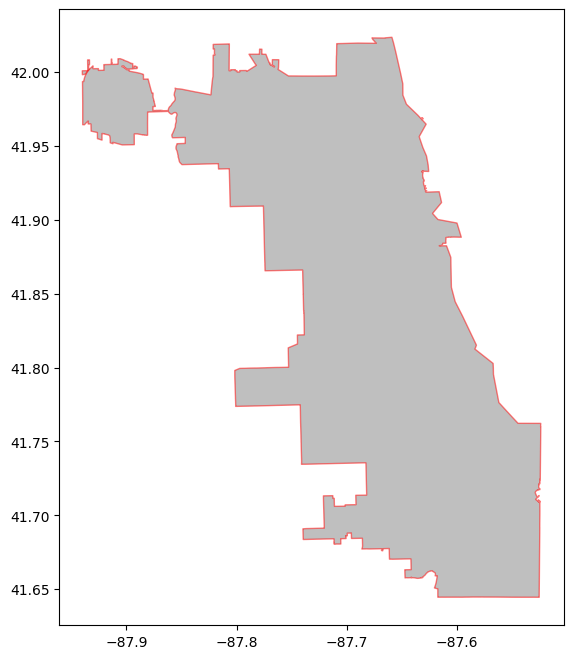

In [16]:
# instead of the tract boundaries -> form into chicago multipolygon
chicago_boundary = gpd.read_file("Chicago_Tracts_2020.zip")
multipolygon = chicago_boundary.dissolve(by=None)
fig, ax = plt.subplots(figsize=(8, 8))
multipolygon.plot(ax=ax, color='grey', edgecolor='red', alpha=0.5)

#### Getis-Ord Gi* Heatmaps:

In [17]:
type(obs_30d)

pandas.core.frame.DataFrame

In [18]:
projected = gpd.GeoDataFrame(obs_30d, geometry=gpd.points_from_xy(obs_30d.lng, obs_30d.lat), crs="EPSG:4326")
projected = projected.to_crs("EPSG:3857")
projected.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [19]:
def create_grid(gdf, cell_size):
    bounds = gdf.total_bounds  # [minx, miny, maxx, maxy]
    xmin, ymin, xmax, ymax = bounds
    rows = int((ymax - ymin) / cell_size)
    cols = int((xmax - xmin) / cell_size)
    
    grid_cells = []
    for i in range(cols):
        for j in range(rows):
            x1 = xmin + i * cell_size
            y1 = ymin + j * cell_size
            x2 = x1 + cell_size
            y2 = y1 + cell_size
            grid_cells.append(box(x1, y1, x2, y2))
    
    grid = gpd.GeoDataFrame({'geometry': grid_cells}, crs=gdf.crs)
    return grid

In [20]:
cell_size = 500  # in meters, balanced for the # of data i have
grid = create_grid(projected, cell_size)
grid

,geometry
0,"POLYGON ((-9794530.047 5100992.993, -9794530.0..."
1,"POLYGON ((-9794530.047 5101492.993, -9794530.0..."
2,"POLYGON ((-9794530.047 5101992.993, -9794530.0..."
3,"POLYGON ((-9794530.047 5102492.993, -9794530.0..."
4,"POLYGON ((-9794530.047 5102992.993, -9794530.0..."
...,...
16269,"POLYGON ((-9743530.047 5177492.993, -9743530.0..."
16270,"POLYGON ((-9743530.047 5177992.993, -9743530.0..."
16271,"POLYGON ((-9743530.047 5178492.993, -9743530.0..."
16272,"POLYGON ((-9743530.047 5178992.993, -9743530.0..."


In [21]:
joined = gpd.sjoin(projected, grid, predicate="within")
counts = joined.groupby('index_right').size()
grid['count'] = counts
grid['count'] = grid['count'].fillna(0)

In [22]:
# Spatial weights
w = libpysal.weights.Queen.from_dataframe(grid)
w.transform = 'r'

# Gi* statistic
gi_star = getisord.G_Local(grid['count'], w)

# Add results to grid
grid['GiZ'] = gi_star.Zs  # Z-scores
grid['pval'] = gi_star.p_sim

C:\Users\ITO\AppData\Local\Temp\ipykernel_12676\3849626196.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Queen.from_dataframe(grid)


In [23]:
multipolygon = multipolygon.to_crs(grid.crs)

In [ ]:
# significant points only filter:
# significant = grid[grid['pval'] < 0.05]

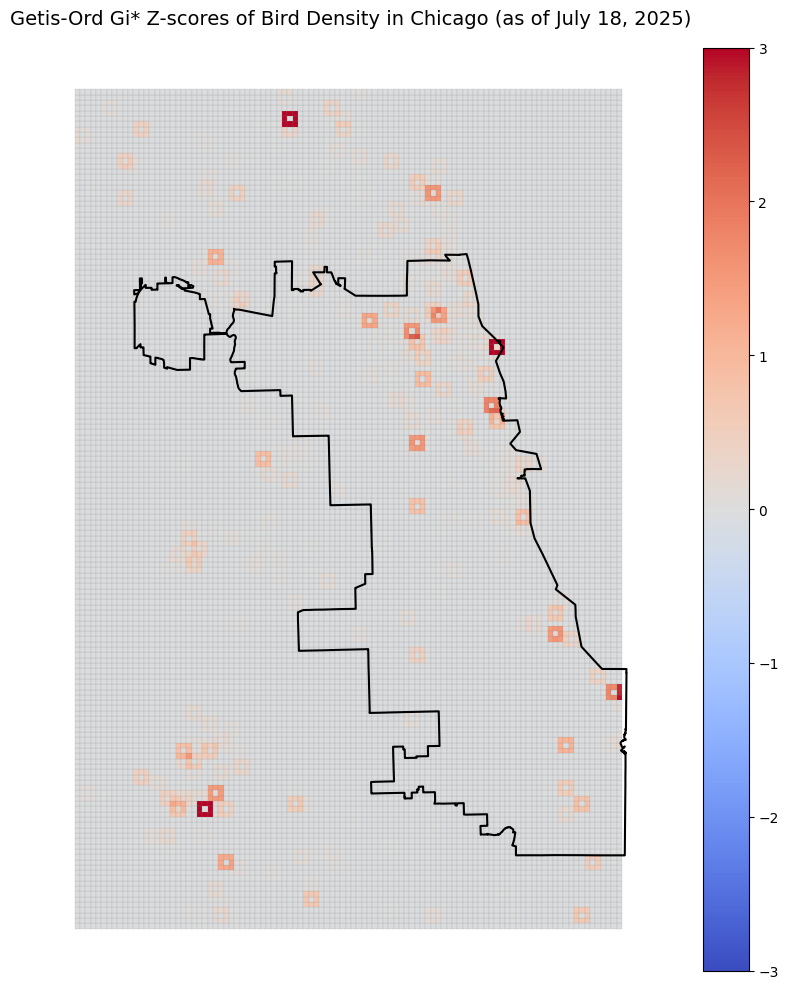

In [28]:
fig, ax = plt.subplots(figsize=(10, 10))

# significant = grid[grid['pval'] < 0.05]

# Plot Gi* heatmap
grid.plot(column='GiZ', cmap='coolwarm', 
          vmin=-3, vmax=3,
          linewidth=0.1, ax=ax, edgecolor='grey', legend=True)

# Overlay Chicago boundary
multipolygon.boundary.plot(ax=ax, color='black')

# Final touches
ax.set_title("Getis-Ord Gi* Z-scores of Bird Density in Chicago (as of July 18, 2025)", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()